## 1. Importing packages and data
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_458/img/candy.jpg" alt="Bowl of halloween candy"></p>
<p>With Halloween just around the corner, it seems like everyone has candy on the brain! There's a great dataset from <a href="https://fivethirtyeight.com/">FiveThirtyEight</a> that includes all sorts of different information about different kinds of candy. For example, is it chocolaty? Is there nougat? How does the cost compare to other candies? How many people prefer this candy over another?</p>
<p>We'll run through a whirlwind tour of this dataset and wrap up by trying some modeling techniques out on it! Specifically, we'll take a look at linear and logistic regression.</p>
<p>First things first, let's get our packages and data loaded up and take a look at exactly what we're dealing with.</p>

In [2]:
# Load all the packages we need
library(tidyverse)
library(broom)
library(corrplot)
library(fivethirtyeight)

# Load the candy_rankings dataset from the fivethirtyeight package
data(candy_rankings)

# Take a glimpse() at the dataset
glimpse(candy_rankings)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
<U+221A> ggplot2 3.1.0     <U+221A> purrr   0.2.5
<U+221A> tibble  1.4.2     <U+221A> dplyr   0.7.8
<U+221A> tidyr   0.8.2     <U+221A> stringr 1.3.1
<U+221A> readr   1.2.1     <U+221A> forcats 0.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
corrplot 0.84 loaded


Observations: 85
Variables: 13
$ competitorname   <chr> "100 Grand", "3 Musketeers", "One dime", "One quar...
$ chocolate        <lgl> TRUE, TRUE, FALSE, FALSE, FALSE, TRUE, TRUE, FALSE...
$ fruity           <lgl> FALSE, FALSE, FALSE, FALSE, TRUE, FALSE, FALSE, FA...
$ caramel          <lgl> TRUE, FALSE, FALSE, FALSE, FALSE, FALSE, TRUE, FAL...
$ peanutyalmondy   <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, TRUE, TRUE, TRU...
$ nougat           <lgl> FALSE, TRUE, FALSE, FALSE, FALSE, FALSE, TRUE, FAL...
$ crispedricewafer <lgl> TRUE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FA...
$ hard             <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, F...
$ bar              <lgl> TRUE, TRUE, FALSE, FALSE, FALSE, TRUE, TRUE, FALSE...
$ pluribus         <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, T...
$ sugarpercent     <dbl> 0.732, 0.604, 0.011, 0.011, 0.906, 0.465, 0.604, 0...
$ pricepercent     <dbl> 0.860, 0.511, 0.116, 0.511, 0.511, 0.767, 0.767, 0...
$ winpercent       <d

## 2. Explore the distributions of categorical variables
<p>Let's get started by taking a look at the distributions of each of these binary categorical variables. There are quite a few of them, so we'll have to do some data wrangling to get them in shape for plotting. We'll explore these by making a bar chart showing the breakdown of each column. This lets us get a sense of the proportion of <code>TRUE</code>s and <code>FALSE</code>s in each column. To do this you'll use the <code>gather()</code> function to get a dataset that looks something like this:</p>
<pre><code>  competitorname sugarpercent pricepercent winpercent feature   value
  &lt;chr&gt;                 &lt;dbl&gt;        &lt;dbl&gt;      &lt;dbl&gt; &lt;chr&gt;     &lt;lgl&gt;
1 100 Grand             0.732        0.860       67.0 chocolate TRUE 
2 3 Musketeers          0.604        0.511       67.6 chocolate TRUE 
3 One dime              0.011        0.116       32.3 chocolate FALSE
</code></pre>

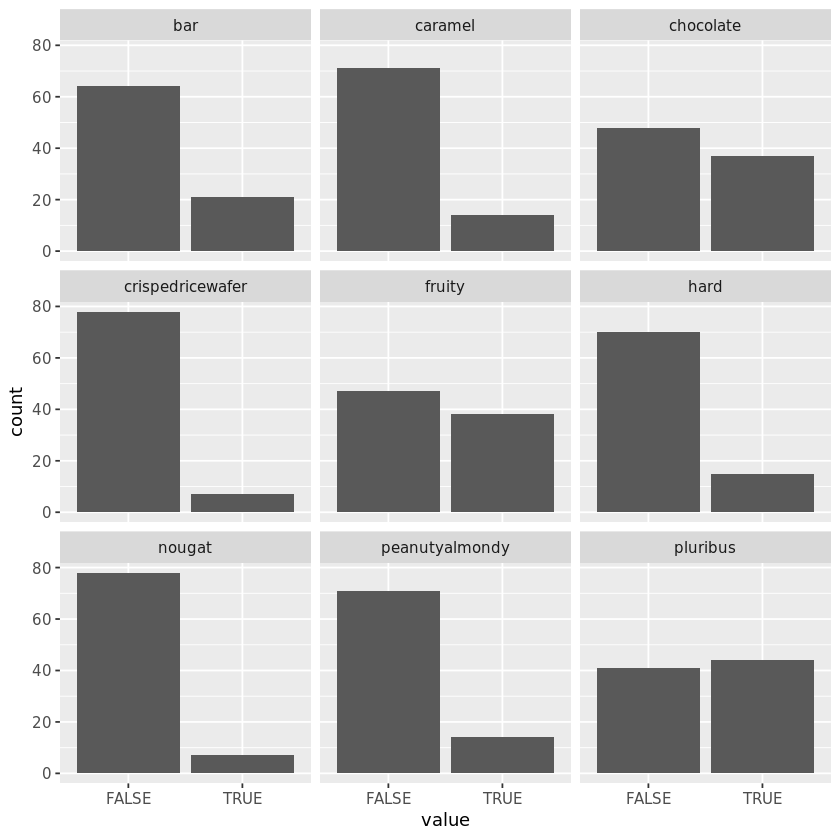

In [4]:
# gather() the categorical variables to make them easier to plot
candy_rankings_long <- gather(data = candy_rankings, key = 'feature', value = 'value', chocolate:pluribus)

# Make a bar plot showing the distribution of each variable
ggplot(data = candy_rankings_long, aes(value)) +
    geom_bar() +
    facet_wrap(~feature)

## 3. Taking a look at pricepercent
<p>Next, we'll look at the <code>pricepercent</code> variable. This variable records the percentile rank of the candy's price against all the other candies in the dataset. Let's see which is the most expensive and which is the least expensive by making a lollipop chart. One of the most interesting aspects of this chart is that a lot of the candies share the same ranking, so it looks like quite a few of them are the same price.</p>

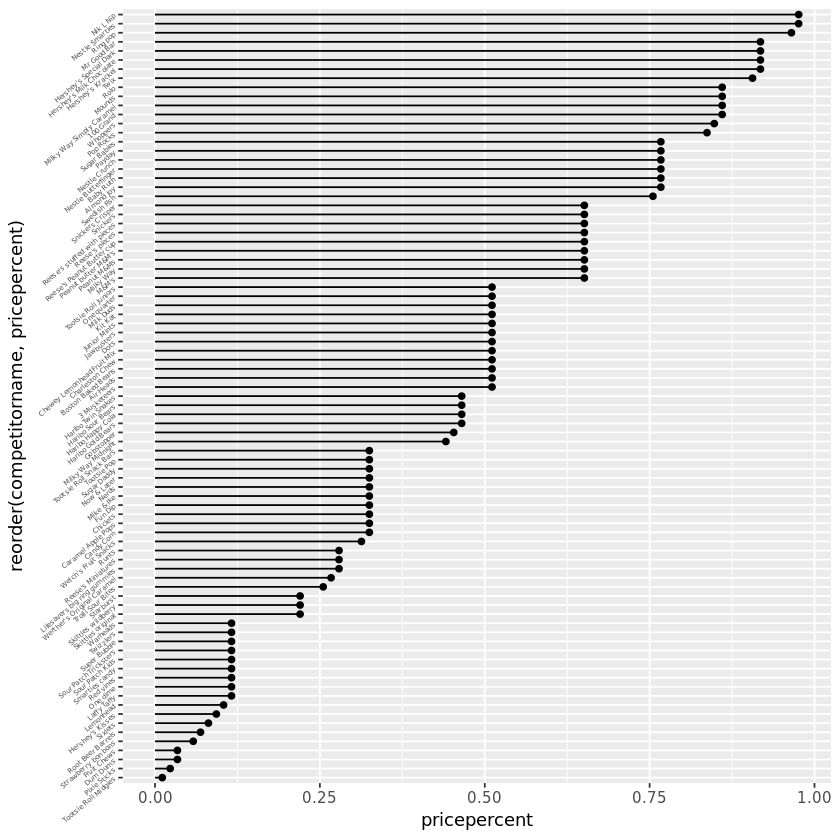

In [6]:
# Make a lollipop chart of pricepercent
ggplot(data = candy_rankings, aes(x = reorder(competitorname, pricepercent), y = pricepercent)) + 
    geom_segment(aes(xend = reorder(competitorname, pricepercent), yend = 0 )) +
    geom_point() +
    coord_flip() +
    theme(axis.text.y = element_text(size = 4, angle = 40))

## 4. Exploring winpercent (part i)
<p>Moving on, we'll take a look at another numerical variable in the dataset: <code>winpercent</code>. This variable records the percentage of people who prefer this candy over another randomly chosen candy from the dataset. We'll start with a histogram! The distribution of rankings looks pretty symmetrical, and seems to center on about 45%. </p>

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


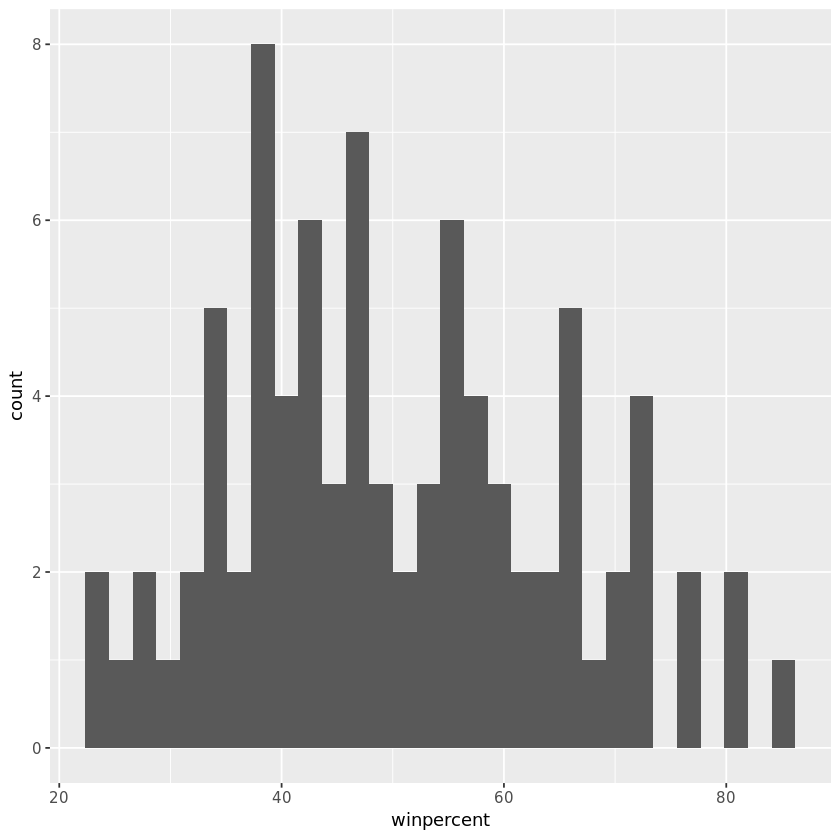

In [8]:
# Plot a histogram of winpercent
ggplot(data = candy_rankings, aes(winpercent)) +
    geom_histogram()

## 5. Exploring winpercent (part ii)
<p>Now that we've looked at the histogram, let's make another lollipop chart to visualize the rankings. It looks like Reese's Peanut Butter Cups are the all time favorite out of this set of candies!</p>

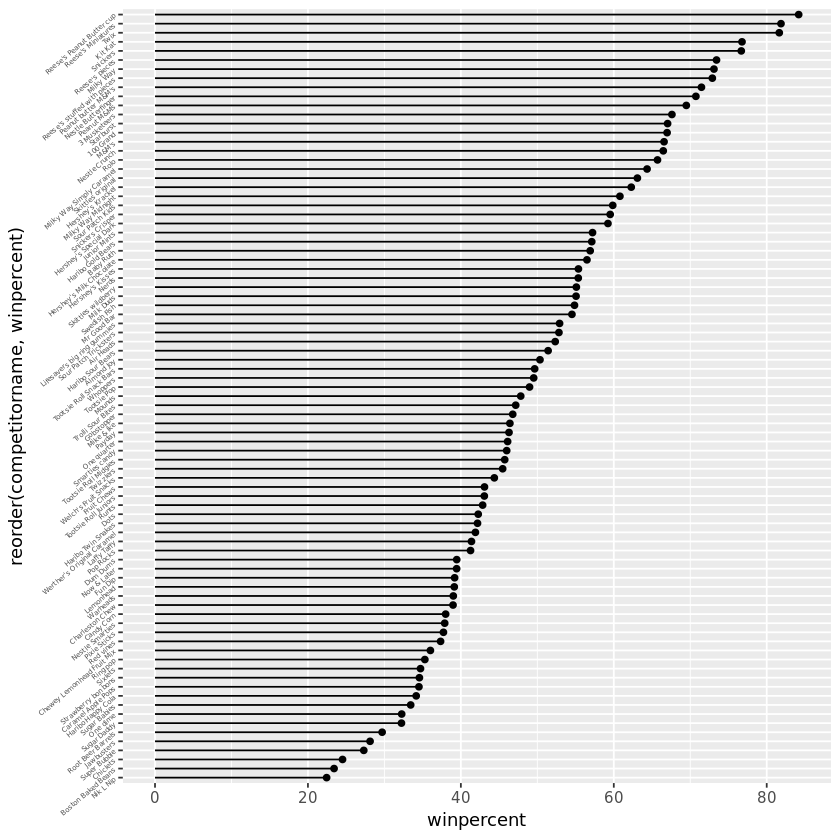

In [10]:
# Make a lollipop chart of winpercent
ggplot(data = candy_rankings, aes(x = reorder(competitorname, winpercent), y = winpercent)) + 
    geom_segment(aes(xend = reorder(competitorname, winpercent), yend = 0 )) +
    geom_point() +
    coord_flip() +
    theme(axis.text.y = element_text(size = 4, angle = 40))

## 6. Exploring the correlation structure
<p>Now that we've explored the dataset one variable at a time, we'll see how the variables interact with one another. This is important as we get ready to model the data because it gives us some intuition about which variables might be useful explanatory variables. We'll use the <code>corrplot</code> package to plot the correlation matrix. Taking a look at this plot, it looks like chocolaty candies are almost never fruity. I can certainly see why that's the case! This also allows us to check for possible <a href="https://en.wikipedia.org/wiki/Multicollinearity">multicollinearity</a>, which can be a problem for regression modeling. It looks like we're good though!</p>

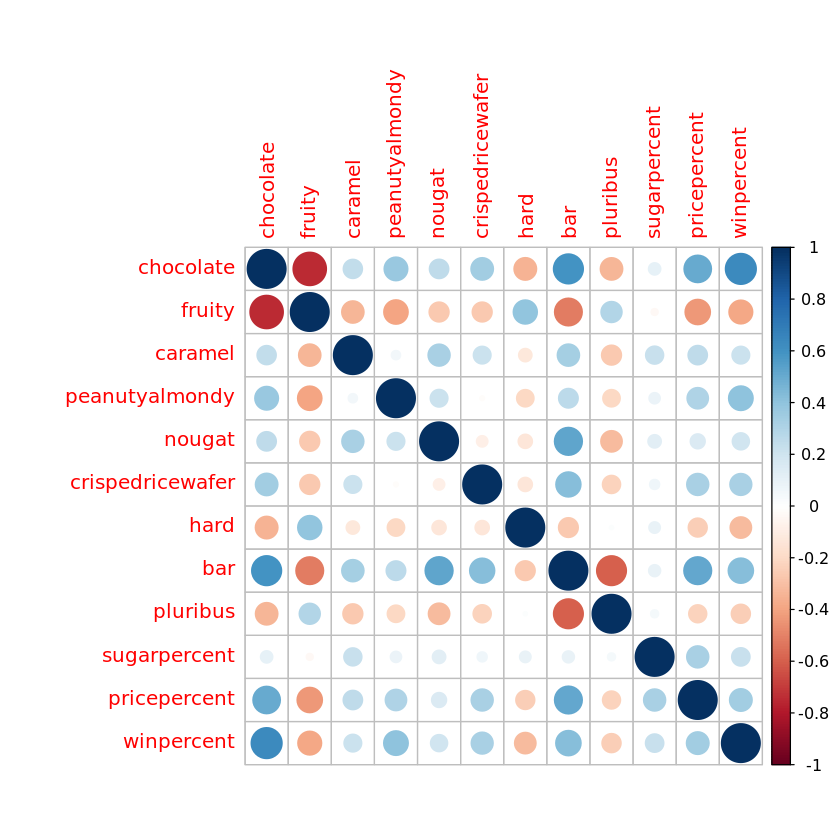

In [12]:
# Plot the correlation matrix using corrplot()
candy_rankings %>% 
    select(-competitorname) %>% 
    cor() %>% 
    corrplot()

## 7. Fitting a linear model of winpercent
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_458/img/snickers.jpg" style="float: left;margin:5px 20px 5px 1px;max-width: 33%"></p>
<p>Let's dive into the deep end of modeling by creating a linear model of <code>winpercent</code> using all the other variables (except <code>competitorname</code>). Because this is a categorical variable with a unique value in every row of the dataset, it's actually mathematically impossible to fit a linear model with it. Moreover, this variable doesn't actually include any information that our model could use because these names don't actually relate to any of the attributes of the candy.</p>
<p>Let's fit this model, then we can dive into exploring it shortly. Maybe this will give us an idea of why people tend to prefer one candy over another!</p>

In [14]:
# Fit a linear model of winpercent explained by all variables 
# except competitorname
win_mod <- lm(winpercent ~ .-competitorname, data = candy_rankings)
win_mod


Call:
lm(formula = winpercent ~ . - competitorname, data = candy_rankings)

Coefficients:
         (Intercept)         chocolateTRUE            fruityTRUE  
             34.5340               19.7481                9.4223  
         caramelTRUE    peanutyalmondyTRUE            nougatTRUE  
              2.2245               10.0707                0.8043  
crispedricewaferTRUE              hardTRUE               barTRUE  
              8.9190               -6.1653                0.4415  
        pluribusTRUE          sugarpercent          pricepercent  
             -0.8545                9.0868               -5.9284  


## 8. Evaluating the linear model
<p>Let's see how we did! We'll take a look at the results of our linear model and run some basic diagnostics to make sure the output is reliable.</p>
<p>Taking a look at the coefficients, we can make some conclusions about the factors that cause people to choose one candy over another. For example, it looks like people who took this survey really like peanut butter! There are a few other significant coefficients. Which ones are these?</p>


Call:
lm(formula = winpercent ~ . - competitorname, data = candy_rankings)

Residuals:
     Min       1Q   Median       3Q      Max 
-20.2244  -6.6247   0.1986   6.8420  23.8680 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           34.5340     4.3199   7.994 1.44e-11 ***
chocolateTRUE         19.7481     3.8987   5.065 2.96e-06 ***
fruityTRUE             9.4223     3.7630   2.504  0.01452 *  
caramelTRUE            2.2245     3.6574   0.608  0.54493    
peanutyalmondyTRUE    10.0707     3.6158   2.785  0.00681 ** 
nougatTRUE             0.8043     5.7164   0.141  0.88849    
crispedricewaferTRUE   8.9190     5.2679   1.693  0.09470 .  
hardTRUE              -6.1653     3.4551  -1.784  0.07852 .  
barTRUE                0.4415     5.0611   0.087  0.93072    
pluribusTRUE          -0.8545     3.0401  -0.281  0.77945    
sugarpercent           9.0868     4.6595   1.950  0.05500 .  
pricepercent          -5.9284     5.5132  -1.075  0.28578    

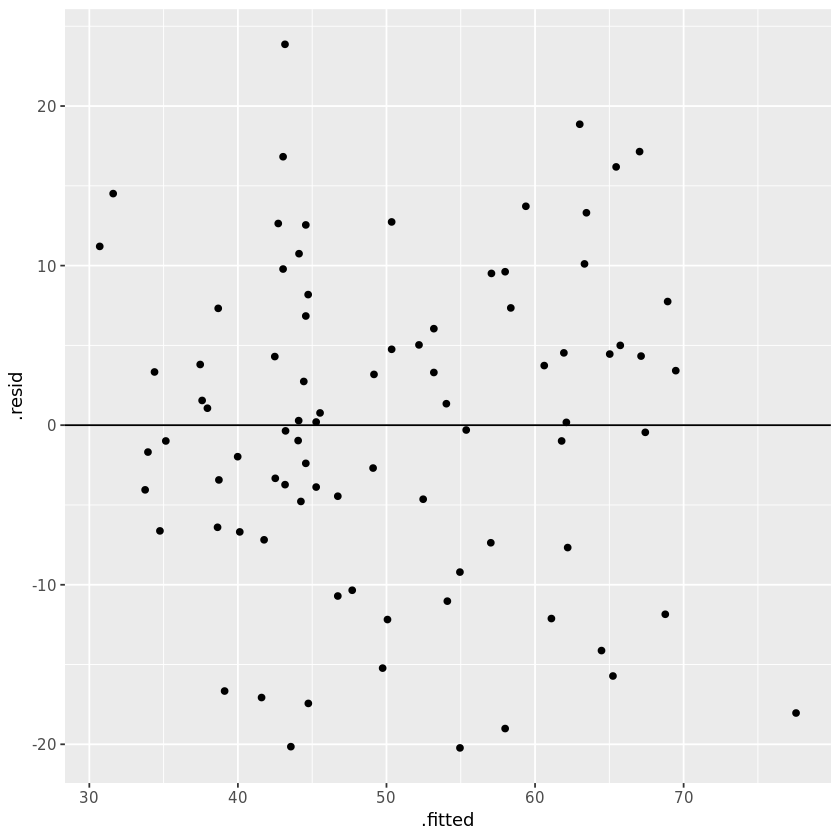

In [16]:
# Take a look at the summary
summary(win_mod)

# Plot the residuals vs the fitted values
ggplot(data = augment(win_mod), aes(x = .fitted, y = .resid)) +
    geom_point() +
    geom_hline(yintercept = 0)

## 9. Fit a logistic regression model of chocolate
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_458/img/chocolate.jpg" style="float: left;margin:5px 20px 5px 1px;max-width: 33%"></p>
<p>Now let's try out logistic regression! We'll be trying to predict if a candy is chocolaty or not based on all the other features in the dataset. A logistic regression is a great choice for this particular modeling task because the variable we're trying to predict is either <code>TRUE</code> or <code>FALSE</code>. The logistic regression model will output a probability that we can use to make our decision. This model outputs a warning because a few of the features (like <code>crispedricewafer</code>) are only ever true when a candy is chocolate. This means that we can't draw conclusions from the coefficients, but we can still use the model to make predictions just fine!</p>

In [18]:
# Fit a glm() of chocolate
choc_mod <- glm(formula = chocolate ~ .-competitorname, data = candy_rankings, family = 'binomial')
choc_mod

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Call:  glm(formula = chocolate ~ . - competitorname, family = "binomial", 
    data = candy_rankings)

Coefficients:
         (Intercept)            fruityTRUE           caramelTRUE  
            -10.2937               -6.7531               -1.8509  
  peanutyalmondyTRUE            nougatTRUE  crispedricewaferTRUE  
             -4.1191              -16.7482               14.9833  
            hardTRUE               barTRUE          pluribusTRUE  
              1.8350               19.0680                0.2280  
        sugarpercent          pricepercent            winpercent  
              0.1217                1.7663                0.2302  

Degrees of Freedom: 84 Total (i.e. Null);  73 Residual
Null Deviance:	    116.4 
Residual Deviance: 25.8 	AIC: 49.8

## 10. Evaluate the logistic regression model
<p>Let's take our logistic regression model out for a spin! We'll start by creating a data frame of predictions we can compare to the actual values. Then we'll evaluate the model by making a confusion matrix and calculating the accuracy.</p>
<p>Looking at the summary, it looks like most of the coefficients aren't statistically significant. In this case, that's okay because we're not trying to draw any conclusions about the relationships between the predictor variables and the response. We're only trying to make accurate predictions and, taking a look at our confusion matrix, it seems like we did a pretty good job!</p>

In [29]:
# Print the summary
summary(choc_mod)

# Make a dataframe of predictions
preds <- augment(choc_mod, type.predict = 'response') %>% 
    mutate(prediction = .fitted > 0.5)

# Create the confusion matrix
conf_mat <- preds %>% 
    select(chocolate, prediction) %>% 
    table()
conf_mat
# Calculate the accuracy
accuracy <- sum(diag(conf_mat))/sum(conf_mat)
accuracy


Call:
glm(formula = chocolate ~ . - competitorname, family = "binomial", 
    data = candy_rankings)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.72224  -0.17612  -0.02787   0.01954   2.57898  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)   
(Intercept)           -10.29370    4.12040  -2.498  0.01248 * 
fruityTRUE             -6.75305    2.20462  -3.063  0.00219 **
caramelTRUE            -1.85093    1.66750  -1.110  0.26700   
peanutyalmondyTRUE     -4.11907    2.98175  -1.381  0.16715   
nougatTRUE            -16.74818 3520.13323  -0.005  0.99620   
crispedricewaferTRUE   14.98331 4725.35051   0.003  0.99747   
hardTRUE                1.83504    1.80742   1.015  0.30997   
barTRUE                19.06799 3520.13379   0.005  0.99568   
pluribusTRUE            0.22804    1.45457   0.157  0.87542   
sugarpercent            0.12168    2.07707   0.059  0.95329   
pricepercent            1.76626    2.24816   0.786  0.43208   
win

         prediction
chocolate FALSE TRUE
    FALSE    47    1
    TRUE      2   35

[1] 0.9647059